# Single-Network Vertex Nomination

Say you're a criminal investigator trying to uncover a human trafficking ring. You build a network of potential suspects: some of the nodes in the network represent human traffickers, and some represent innocent people. The edges of the network represent a working relationship between a given pair of individuals.

Your team has limited resources, and so it's difficult to scrutinize everybody in the network directly to see if they are human traffickers. Ideally, you'd like to use your network to nominate potential suspects, so that you can prioritize your investigative efforts. You've already done some work: you have a list of a few nodes of the network who are known to be traffickers, and you have a list of a few who you know are not. Your goal, then, is to build an ordered list of nodes in the network that are most similar to the nodes you already know belong to human traffickers. Ideally, the first nodes in the list would be more likely to be traffickers, and the nodes would get less and less likely the further down in the list you go.

This is the idea behind *single-network vertex nomination*. You have a group of "seed nodes" that you know have the right community membership, and then you take the rest of the nodes in your network and order them by their relationship to the seed nodes in terms of that community membership. The nomination task here isn't just classification: it's prioritization. You're prioritizing how important the rest of your nodes are with respect to the seed nodes, with the most important nodes at the top.

## Spectral Vertex Nomination

There are a few approaches to vertex nomination. You can take a likelihood-maximization approach, or a bayes-optimal approach - but what we'll focus on is *Spectral Vertex Nomination*. The general idea is that you embed your network, and then you just order the latent positions by how close they are to the seed node latent positions. There are a few ways of doing this: you could create a *separate* set of nominees for each node, for instance. This would correspond to finding the people closest to *each* human trafficker, rather than finding a single list of nominees. You could also just get a single list of nominees: you could first take the centroid of the latent positions of your seed nodes, and then find the closest nodes to that *centroid*. There are also a few different ways of defining what it means to be "close" to seed node latent positions. The obvious way is euclidean distance, which is what you'd traditionally think of as the distance between two points, but you could also use something like the Mahalanobis distance, which is essentially Euclidean distance but with a coordinate system and a rescaling defined by the covariance in your data.

In any case, all forms of Spectral Vertex Nomination involve finding embeddings and then taking distances. In contrast to the other approaches, it scales well with very large networks (since you're essentially just doing an embedding followed by a simple calculation) and doesn't require any prior knowledge of community membership.

Let's see what spectral vertex nomination looks like. Below, we see the latent positions for a network with three communities, where two of the communities are more closely linked than the third community. We do a standard adjacency spectral embedding, and we end up with a set of latent positions. Our seed nodes - the ones whose community membership we know - are marked.

In [1]:
import numpy as np
from graspologic.simulations import sbm
from graspologic.embed import AdjacencySpectralEmbed as ASE

# construct network
n = 100
B = np.array([[0.5, 0.35, 0.2],
              [0.35, 0.6, 0.3],
              [0.2, 0.3, 0.65]])

# Create a network from and SBM, then embed
A, labels = sbm([n, n, n], p=B, return_labels=True)
ase = ASE()
X = ase.fit_transform(A)

# Let's say we know that the first five nodes belong to the first community.
# We'll say that those are our seed nodes.
seeds = np.ones(5)

# grab a set of seed nodes
memberships = labels.copy() + 1
mask = np.zeros(memberships.shape)
seed_idx = np.arange(len(seeds))
mask[seed_idx] = 1
memberships[~mask.astype(bool)] = 0

# find the latent positions for the seed nodes
seed_latents = X[memberships.astype(bool)]

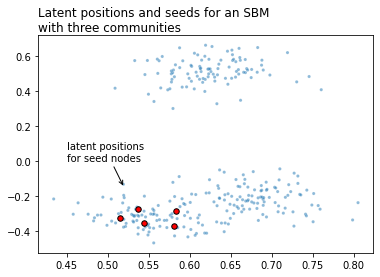

In [2]:
from graphbook_code import plot_latents
import matplotlib.pyplot as plt

plot = plot_latents(X, labels=memberships, title="Latent positions and seeds for an SBM \nwith three communities", 
                    legend=False, palette=["#1f77b4", "#ff0000"], alpha=.5);
plot.scatter(x=seed_latents[:, 0], y=seed_latents[:, 1], marker='o', s=30, edgecolor="black", c="red")
plot.axes.xaxis.set_visible(True)
plot.axes.yaxis.set_visible(True)
plot.annotate(text="latent positions \nfor seed nodes", xytext=(.45, 0), 
              xy=(.52, -.15), arrowprops={"arrowstyle": "->", "color": "k", });

Now, we'd like to order the rest of the vertices in this network by their degree of similarity to the seed nodes. Remember that we talked about two ways of doing this: we could find a separate set of nominations for each seed node, or we could find a single set of nominations for all of the seed nodes. Let's start by finding a single set, using the centroid.

### Finding a single set of nominations

Computing the centroid is as easy as just taking the mean value for the seed latent positions along each coordinate axis. Since our example is in 2 dimensions, we can just take our $m \times 2$ matrix of seed latent positions and take the mean along the first axis to create a $1 \times 2$ vector. That vector will be the centroid, and its location in Euclidean space will be right in the middle of the seeds. You can see the centroid (red star) along with the seed latent positions (red circles) below.

In [3]:
centroid = seed_latents.mean(axis=0)

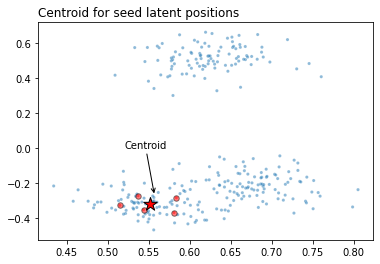

In [4]:
plot = plot_latents(X, labels=memberships, title="Centroid for seed latent positions", 
                    legend=False, palette=["#1f77b4", "#ff0000"], alpha=.5);
plot.scatter(x=seed_latents[:, 0], y=seed_latents[:, 1], marker='o', s=30, 
             edgecolor="black", c="red", alpha=.5)
plot.scatter(x=centroid[0], y=centroid[1], marker='*', s=200, edgecolor="black", c="red")
plot.axes.xaxis.set_visible(True)
plot.axes.yaxis.set_visible(True)
plot.annotate(text="Centroid", xytext=(.52, 0), 
              xy=(centroid[0]+.005, centroid[1]+.05), 
              arrowprops={"arrowstyle": "->", "color": "k", });

Now, all we do is order the rest of the latent positions (the blue dots in the figure above) by their distance to the centroid. The nodes corresponding to the closer latent positions will be higher up in our nomination list. Scikit-learn has a `NearestNeighbors` classifier, so we'll just use that. Below, we fit the classifier to our latent positions matrix, then get our nominations using the `kneighbors` function. The latent positions closer to the centroid are more visible, and they get progressively less visible the further from the centroid they are.

In [5]:
from sklearn.neighbors import NearestNeighbors

# Find the nearest neighbors to the seeds, excluding other seeds
neighbors = NearestNeighbors(n_neighbors=len(X))
neighbors.fit(X)
distances, nominations = neighbors.kneighbors(centroid[np.newaxis, :])

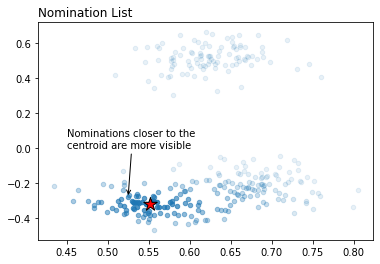

In [6]:
from graphbook_code import plot_latents
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for n, d in zip(nominations.flatten(), distances.flatten()):
    x1, x2 = X[n]
    t = 10
    f = np.exp(-t*d)
    g = t*d**t + 1
    alpha_ = np.amax([f*g, .1])  # Function made through trial and error to get alpha-values looking right
    ax.scatter(x1, x2, s=20, alpha=alpha_, c="#1f77b4")
ax.scatter(x=centroid[0], y=centroid[1], marker='*', s=200, edgecolor="black", c="red")
ax.axes.xaxis.set_visible(True)
ax.axes.yaxis.set_visible(True)
ax.annotate(text="Nominations closer to the \ncentroid are more visible", xytext=(.45, 0), 
              xy=(.525, -.28), arrowprops={"arrowstyle": "->", "color": "k", });
ax.set_title("Nomination List", loc="left");

Let's look at the network directly, and see where our nominations tend to be. Below is a network colored by nomination rank: nodes that are higher up in the nomination list are more purple, and nodes that are lower in the nomination list are more white. You can see that the higher up in the nomination list you get (more purple), the more well-connected nodes tend to be to the seed nodes.

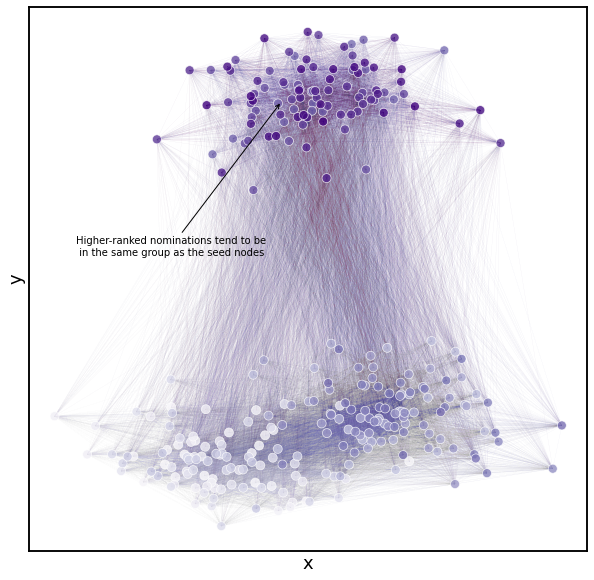

In [7]:
from graphbook_code import networkplot

plot = networkplot(A, x=X[:, 0], y=X[:, 1], node_hue=nominations.flatten(), 
            palette="Purples", edge_alpha=0.05)

plot.annotate(text="Higher-ranked nominations tend to be\n in the same group as the seed nodes", xytext=(.45, .15), 
              xy=(.6, .5), arrowprops={"arrowstyle": "->", "color": "k", });

# TODO: add colorbar

## Finding Nominations for Each Node

Another approach, if we don't want to combine the information from all of our seed nodes, is to create a different nomination list for each node. This would correspond to finding multiple sets of people close to *each* human trafficker, rather than finding a single set of people for the *group* of human traffickers. Graspologic does this natively; the only real difference between the two approaches is that we take the nearest neighbors of the centroid for the first method rather than for each individual. Because of this, we'll just use graspologic directly, rather than showcasing the algorithm.

In [8]:
from graspologic.nominate import SpectralVertexNomination

# Choose the number of nominations we want for each seed node
svn = SpectralVertexNomination(n_neighbors=5)
svn.fit(A)

# get nominations and distances for each seed index
nominations, distances = svn.predict(seed_idx)

Below you can see the nominations for each node. The first row containes the indices for each seed node, and each subsequent row contains the nearest neighbors for those seed nodes.

In [9]:
nominations

array([[ 0,  1,  2,  3,  4],
       [49, 63, 28, 17, 98],
       [96, 19, 32, 56,  5],
       [85, 77, 64, 67, 11],
       [43, 48, 15, 43, 79]])

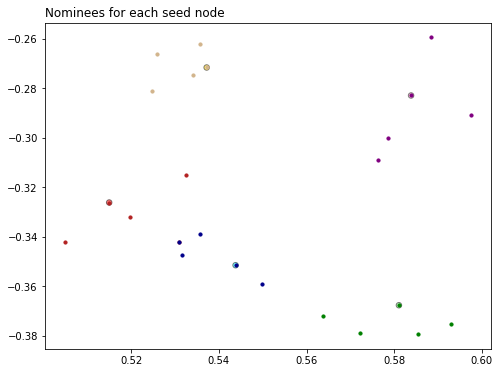

In [10]:
color = ['red', 'lightgreen', 'gold', 'cyan', 'pink']
seed_color = ['firebrick', 'green', 'tan', 'darkblue', 'purple']


fix, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x=seed_latents[:, 0], y=seed_latents[:, 1], marker='o', s=30, 
             edgecolor="black", c=color, alpha=.5)

for i, seed_group in enumerate(nominations.T):
    neighbors = X[seed_group]
    x, y = neighbors[:, 0], neighbors[:, 1]
    ax.scatter(x, y, c=seed_color[i], s=10)
    
ax.set_title("Nominees for each seed node", loc="left");

These approaches are each useful in different situations. 

## References

theory papers:
- theory of consistency and Bayes optimality: On consistent vertex nomination schemes
- dealing with corrupted networks (e.g., not one-to-one correspondence): Vertex Nomination, Consistent Estimation, and Adversarial Modification

applications papers:
- social networks: Vertex nomination via local neighborhood matching
- data associated with human trafficking: Vertex nomination schemes for membership prediction